# MAV - Laboratory 3 -> PAIS

In [84]:
from types import FunctionType

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import boston_housing

In [85]:
(train_x, train_y), (test_x, test_y) = boston_housing.load_data()

##### В конце понадобиться для вывода средних графиков

In [86]:
MEAN_MAE_SCORE: dict = {}
MEAN_MSE_SCORE: dict = {}

In [87]:
print(train_x.shape)
print(test_x.shape)
print(test_x)

(404, 13)
(102, 13)
[[1.80846e+01 0.00000e+00 1.81000e+01 ... 2.02000e+01 2.72500e+01
  2.90500e+01]
 [1.23290e-01 0.00000e+00 1.00100e+01 ... 1.78000e+01 3.94950e+02
  1.62100e+01]
 [5.49700e-02 0.00000e+00 5.19000e+00 ... 2.02000e+01 3.96900e+02
  9.74000e+00]
 ...
 [1.83377e+00 0.00000e+00 1.95800e+01 ... 1.47000e+01 3.89610e+02
  1.92000e+00]
 [3.58090e-01 0.00000e+00 6.20000e+00 ... 1.74000e+01 3.91700e+02
  9.71000e+00]
 [2.92400e+00 0.00000e+00 1.95800e+01 ... 1.47000e+01 2.40160e+02
  9.81000e+00]]


In [88]:
def normalize(train_data, test_data):
    mean = train_data.mean(axis=0)
    train_data -= mean
    std = train_data.std(axis=0)
    train_data /= std
    test_data -= mean
    test_data /= std
    
    return train_data, test_data

In [89]:
from sklearn.preprocessing import StandardScaler

def standardize(train_data, test_data):
    scaler = StandardScaler()
    
    scaled_X_train = scaler.fit_transform(train_data)
    scaled_X_test = scaler.transform(test_data)
    
    return scaled_X_train, scaled_X_test

In [90]:
def build_regression_model():
    model = Sequential()
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [91]:
def hand_cross_validation_model(train_X = train_x, test_X = test_x, train_Y = train_y, k: int = 4, num_epochs: int = 100, batch_size: int = 2, scaling_function = normalize):

    train_data, test_data = scaling_function(train_X, test_X)
    
    num_val_samples: int = len(train_data) // k
    all_scores_mae: list = []
    all_losses_mse: list = []
    
    for i in range(k):
        print('processing fold #', i)
        val_data = train_data[i *  num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_Y[i * num_val_samples: (i + 1) * num_val_samples]
    
        partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate([train_Y[:i * num_val_samples], train_Y[(i + 1) * num_val_samples:]], axis=0)
    
        model = build_regression_model()
        history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=0)
    
        history_df = pd.DataFrame(history.history)
    
        fig, axes = plt.subplots(1, 2, figsize=(15,7))

        sns.lineplot(data=history_df['mae'], ax=axes[0], color='red')
        sns.lineplot(data=history_df['val_mae'], ax=axes[0],  color='green')
        axes[0].set_title(f'Mae in {i + 1} iteration')

        sns.lineplot(data=history_df['loss'], ax=axes[1], color='red')
        sns.lineplot(data=history_df['val_loss'], ax=axes[1], color='green')
        axes[1].set_title(f'Loss in {i + 1} iteration')
        
        val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
        
        all_scores_mae.append(val_mae)
        all_losses_mse.append(val_mse)
        
        
        
    print(f'All Scores MAE: {all_scores_mae}')
    print(f'Mean of MAE score ---> {np.mean(all_scores_mae)}')
    
    print(f'All Losses MSE: {all_losses_mse}')
    print(f'Mean of MSE loss ---> {np.mean(all_losses_mse)}')  
    
    return np.mean(all_scores_mae), np.mean(all_losses_mse)


##### Обучение и построение модели на чистых данных `Hold-Out` -> обучение `test` <-> `train`  

In [92]:
def final_evaluation(num_epochs: int = 100, batch_size: int = 10):
    model_without_CV = build_regression_model()
    train_data, test_data = standardize(train_x, test_x)

    history = model_without_CV.fit(train_data, train_y, epochs=num_epochs, batch_size=batch_size, validation_split=0.1)

    history_df = pd.DataFrame(history.history)

    fig, axes = plt.subplots(1, 2, figsize=(15,7))

    sns.lineplot(data=history_df['mae'], ax=axes[0], color='red')
    sns.lineplot(data=history_df['val_mae'], ax=axes[0],  color='green')
    axes[0].set_title('Mae')

    sns.lineplot(data=history_df['loss'], ax=axes[1], color='red')
    sns.lineplot(data=history_df['val_loss'], ax=axes[1], color='green')
    axes[1].set_title('Loss')
    
    final_mae, final_mse = model_without_CV.evaluate(test_data, test_y)
    
    print(f'Final MAE ---> {final_mae}')
    print(f'Final MSE ---> {final_mse}')
    

##### Starting Analysis...

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
All Scores MAE: [2.477491855621338, 2.4790172576904297, 2.8243601322174072, 2.4847657680511475]
Mean of MAE score ---> 2.5664087533950806
All Losses MSE: [9.582931518554688, 10.305438041687012, 15.17786979675293, 12.894625663757324]
Mean of MSE loss ---> 11.990216255187988


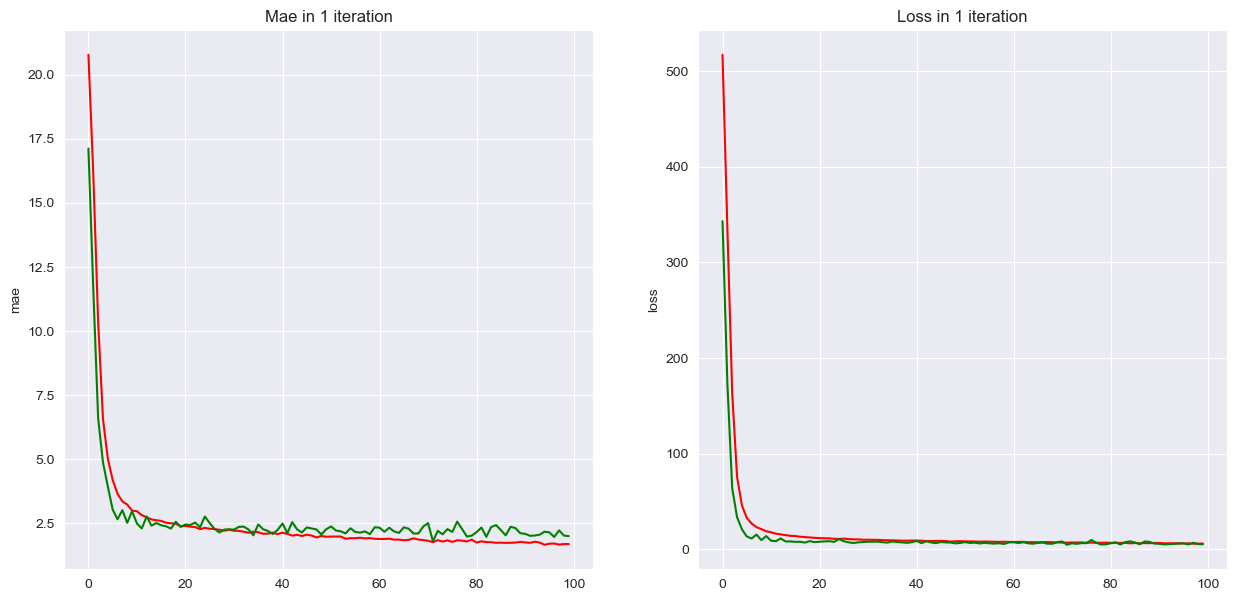

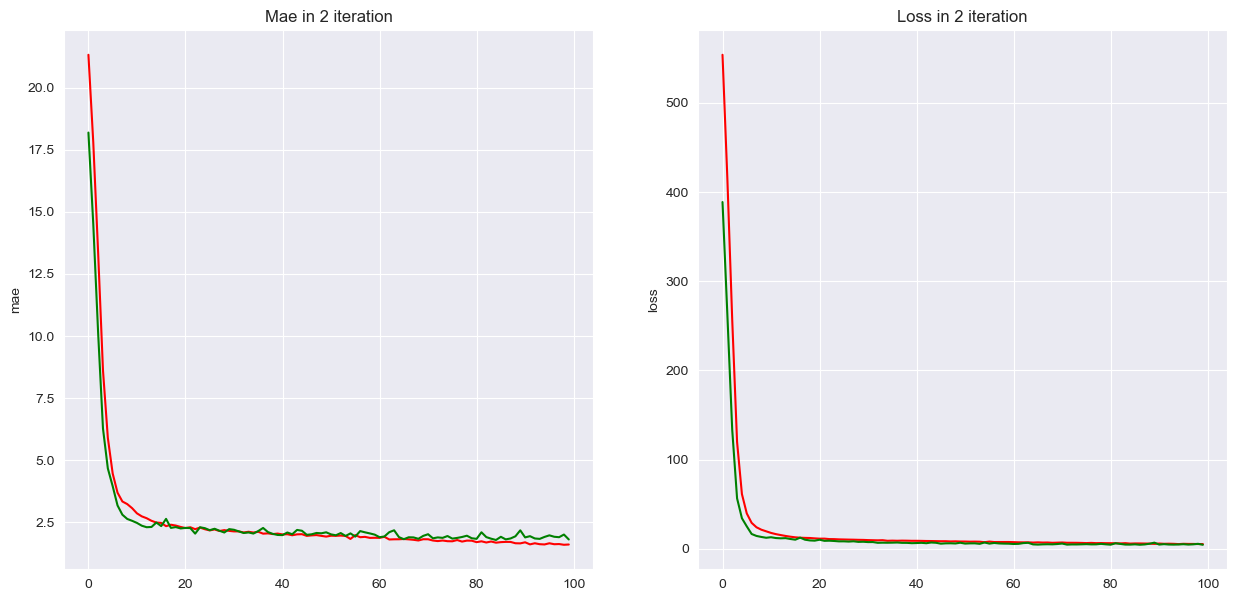

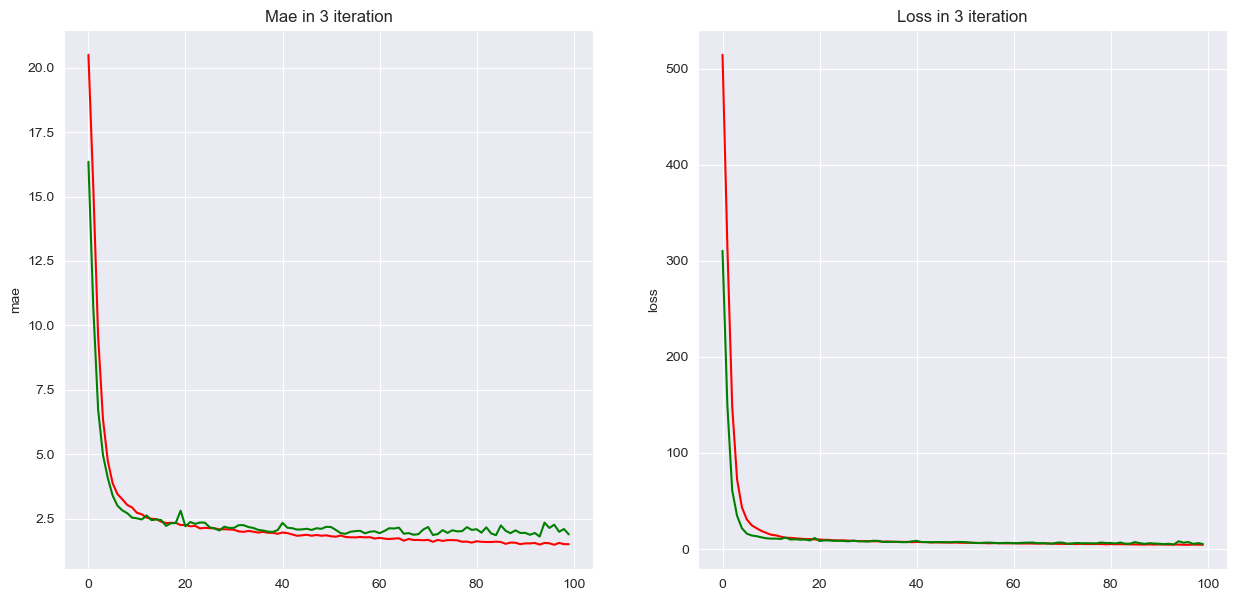

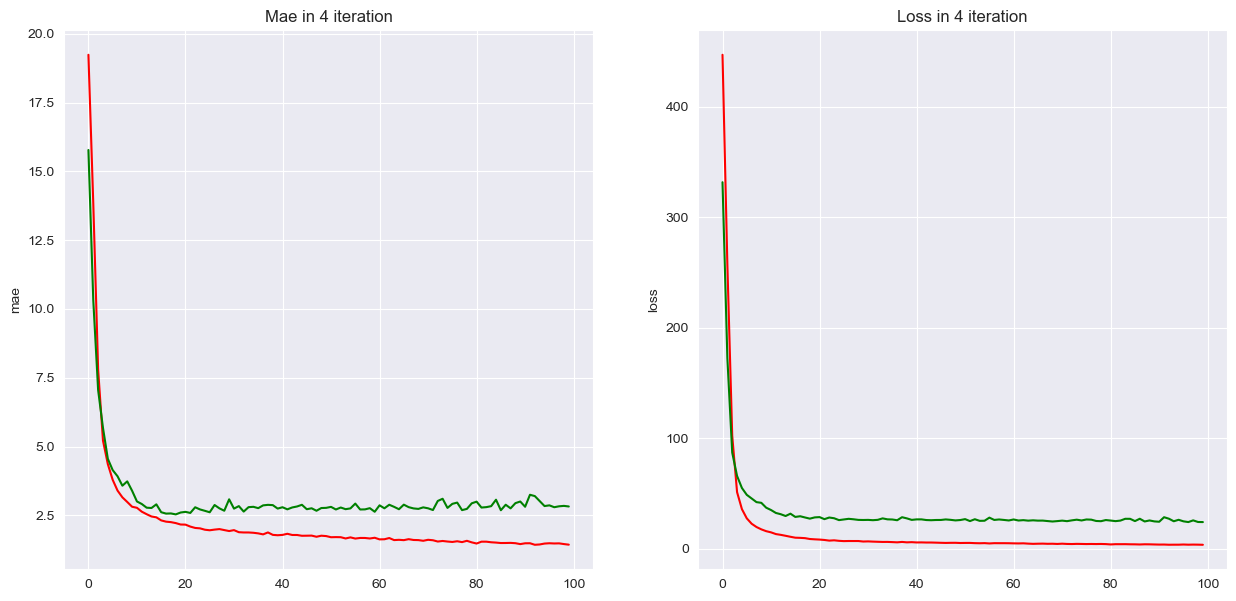

In [93]:
MAE, MSE = hand_cross_validation_model(batch_size=10, num_epochs=100)
MEAN_MAE_SCORE['default'] = MAE
MEAN_MSE_SCORE['default'] = MSE

processing fold # 0
processing fold # 1
All Scores MAE: [2.7073779106140137, 2.8850157260894775]
Mean of MAE score ---> 2.7961968183517456
All Losses MSE: [13.556965827941895, 18.04371452331543]
Mean of MSE loss ---> 15.800340175628662


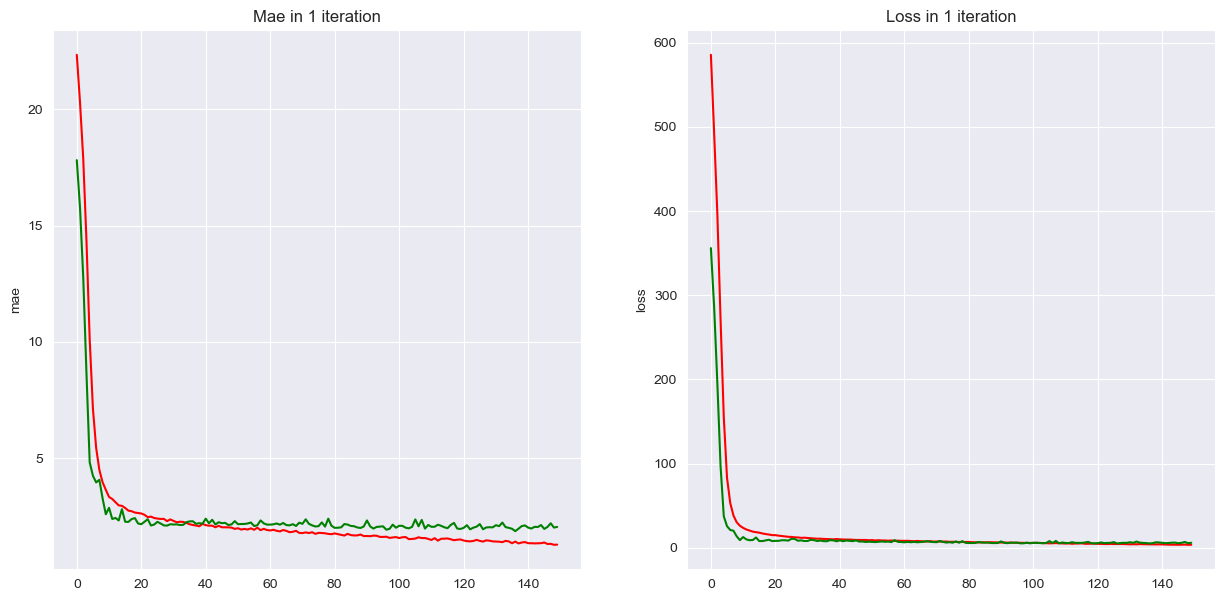

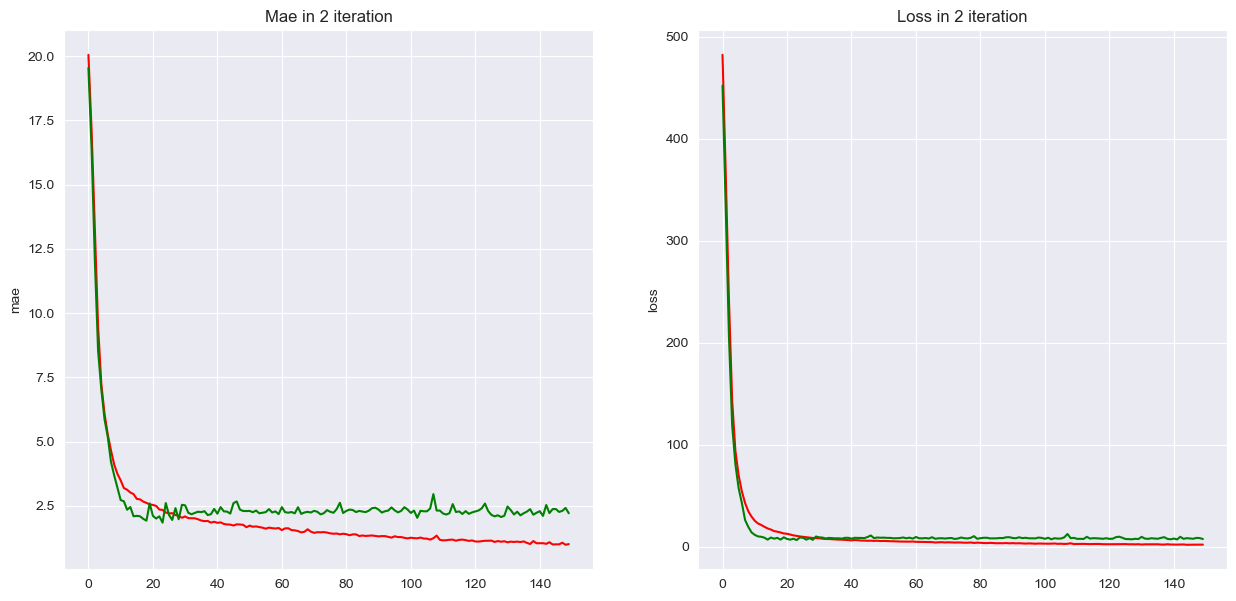

In [94]:
MAE, MSE = hand_cross_validation_model(k=2, batch_size=10, num_epochs=150, scaling_function=standardize)
MEAN_MAE_SCORE['k=2 e=150'] = MAE
MEAN_MSE_SCORE['k=2 e=150'] = MSE

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 530.3973 - mae: 21.0017 - val_loss: 334.4663 - val_mae: 16.5994
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 303.2885 - mae: 14.7363 - val_loss: 132.2286 - val_mae: 9.9764
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 128.9194 - mae: 9.3949 - val_loss: 46.5547 - val_mae: 5.9322
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 50.3794 - mae: 5.5690 - val_loss: 26.7279 - val_mae: 4.2851
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36.4586 - mae: 4.1647 - val_loss: 18.4902 - val_mae: 3.5617
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23.3605 - mae: 3.4627 - val_loss: 18.9737 - val_mae: 3.5434
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.8902 - mae: 2.9923 - val_loss: 14.1680 - val_mae: 2.9523
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 16.8921 - mae: 2.8992 - val_loss: 16.3220 - val_mae: 3.1928
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━

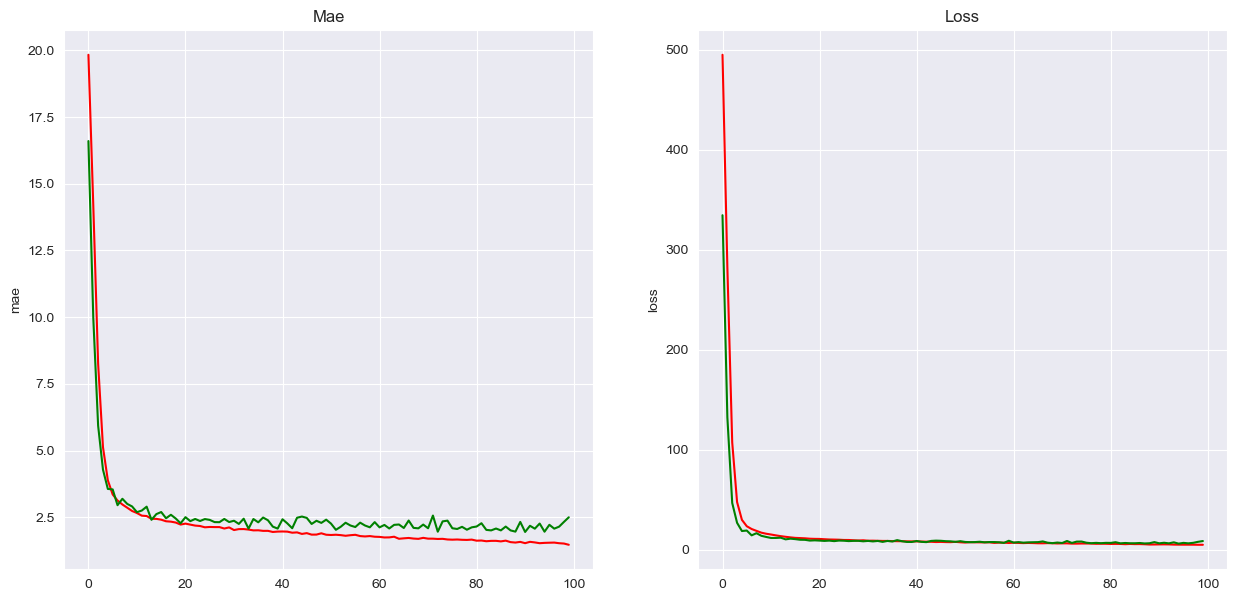

In [95]:
final_evaluation()

##### `w_OF` -> without overfitting

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9
All Scores MAE: [1.8497806787490845, 1.7399104833602905, 2.446010112762451, 2.705488681793213, 2.093151807785034, 2.5042195320129395, 2.4567229747772217, 2.5108864307403564, 2.7169582843780518, 2.471825122833252]
Mean of MAE score ---> 2.3494954109191895
All Losses MSE: [9.82975959777832, 4.4390869140625, 10.649242401123047, 13.54023551940918, 6.972179412841797, 9.661148071289062, 10.185460090637207, 19.508703231811523, 15.4462251663208, 11.496923446655273]
Mean of MSE loss ---> 11.172896385192871


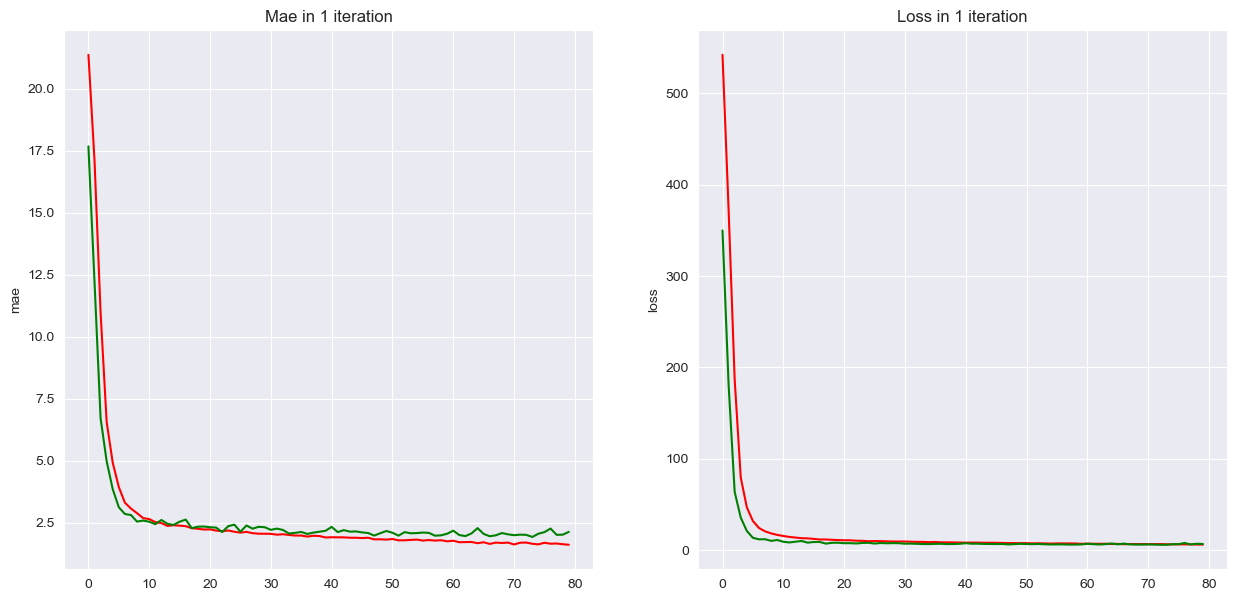

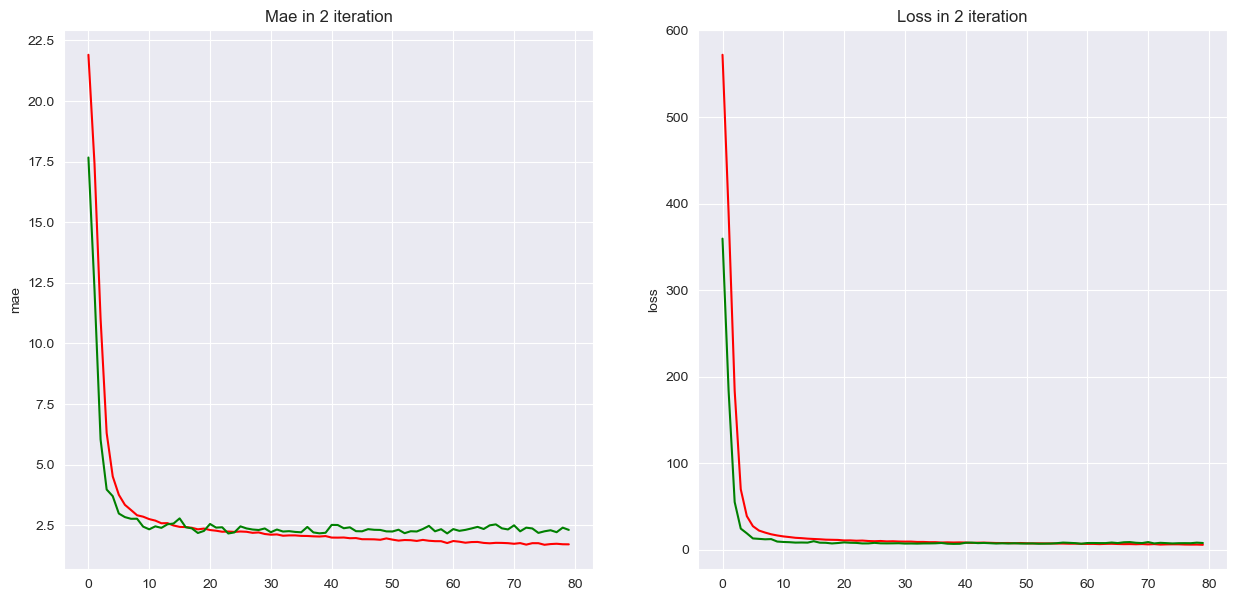

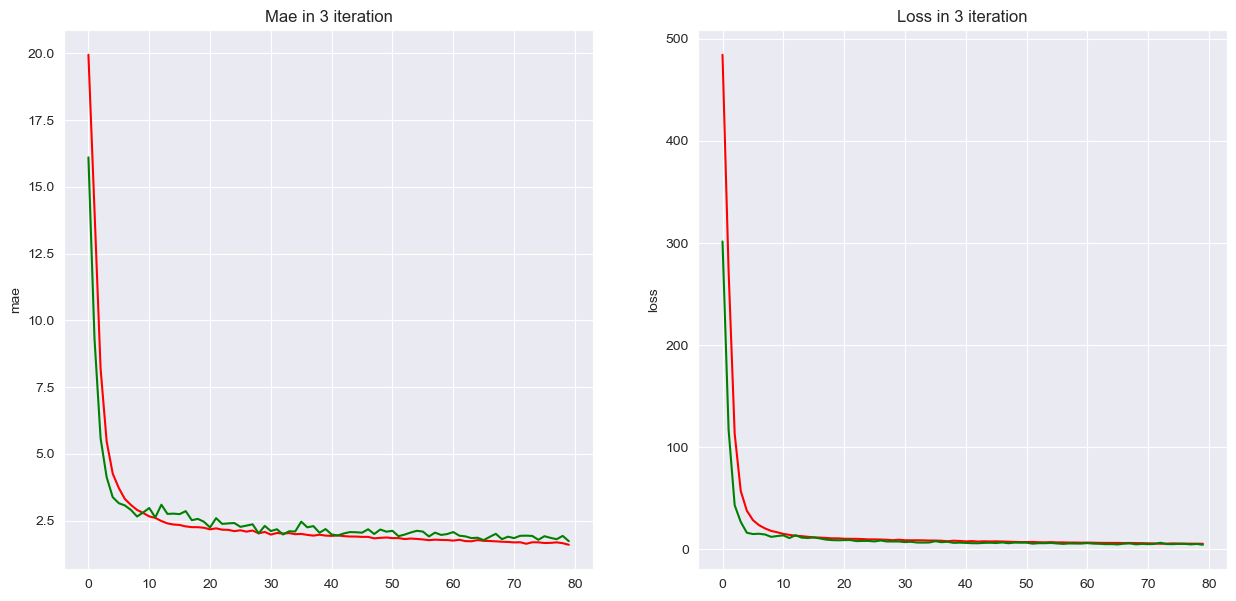

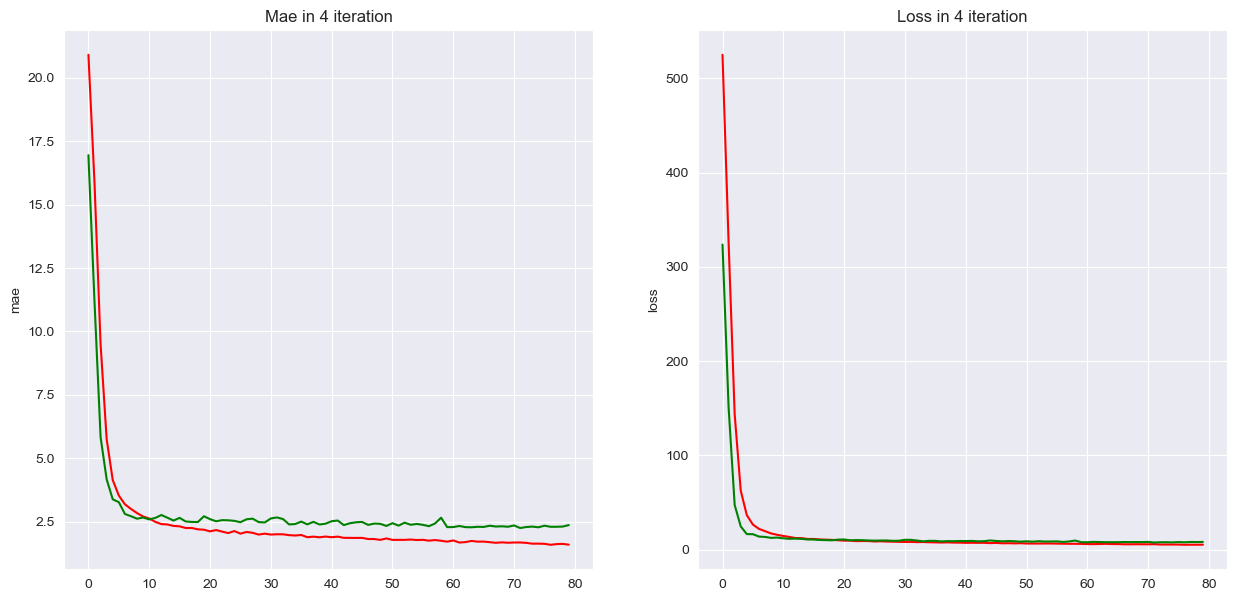

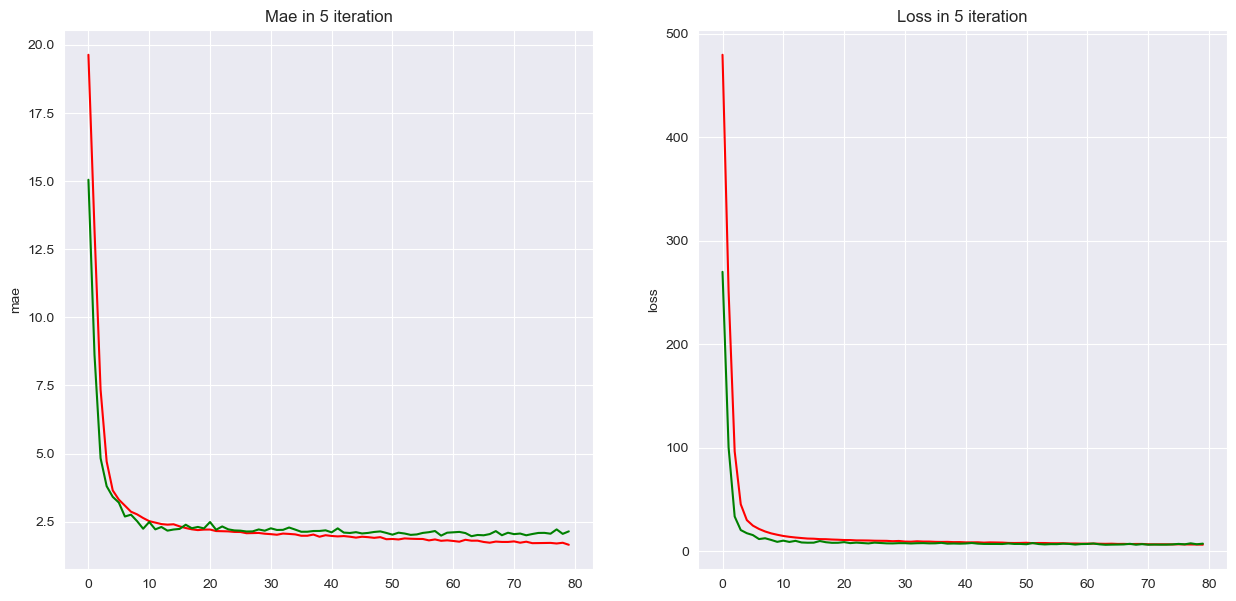

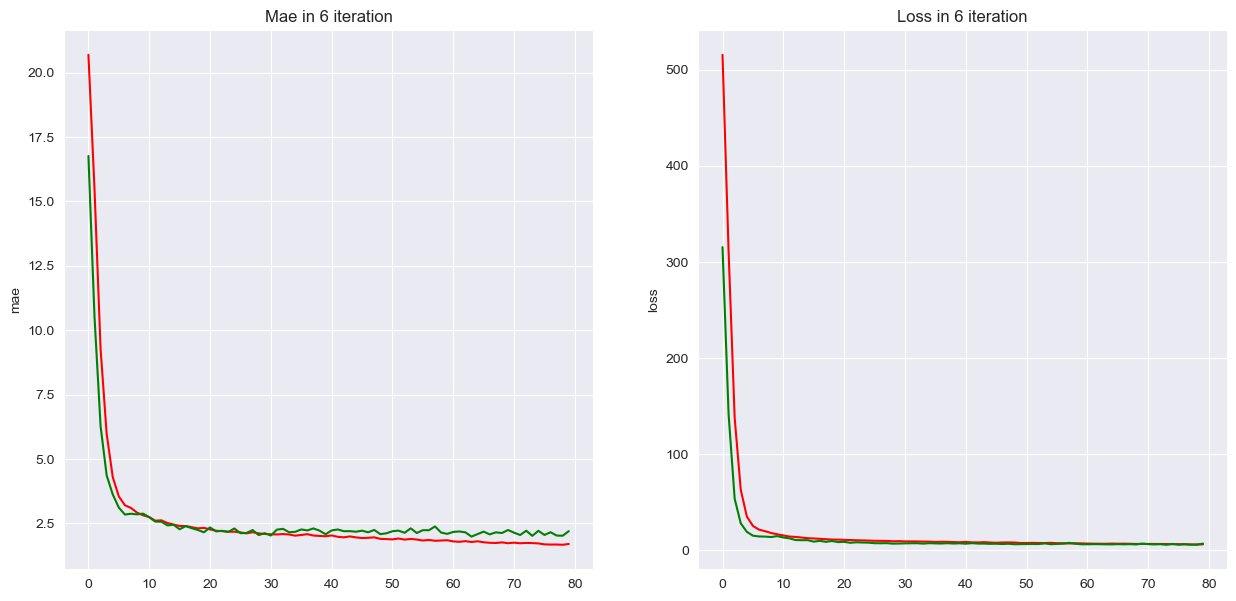

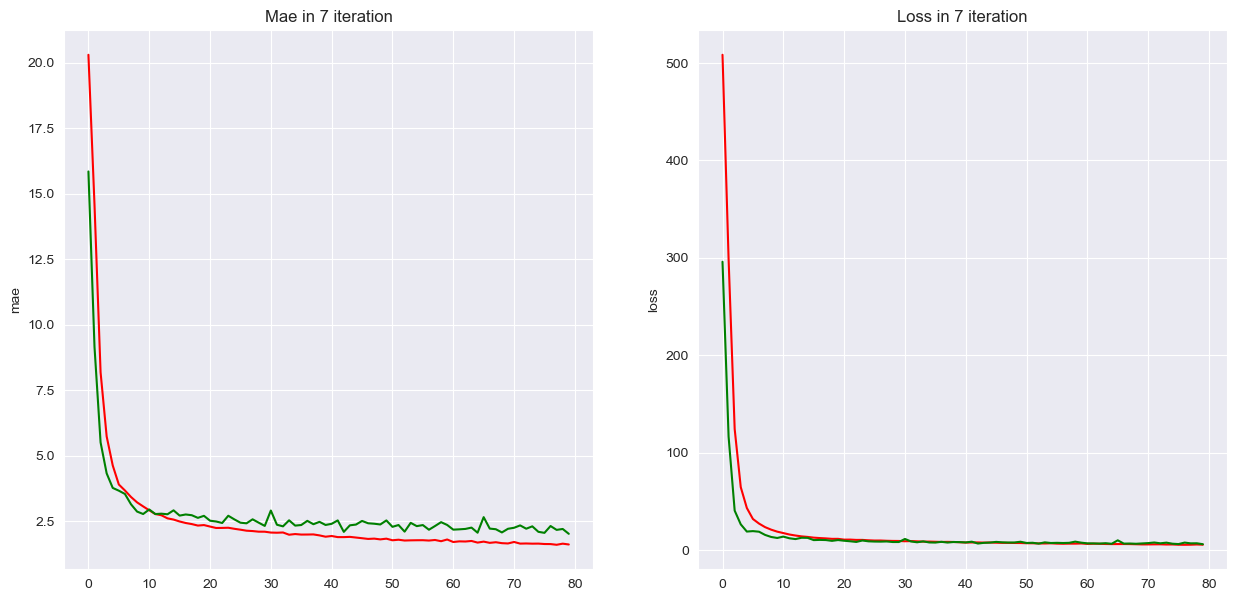

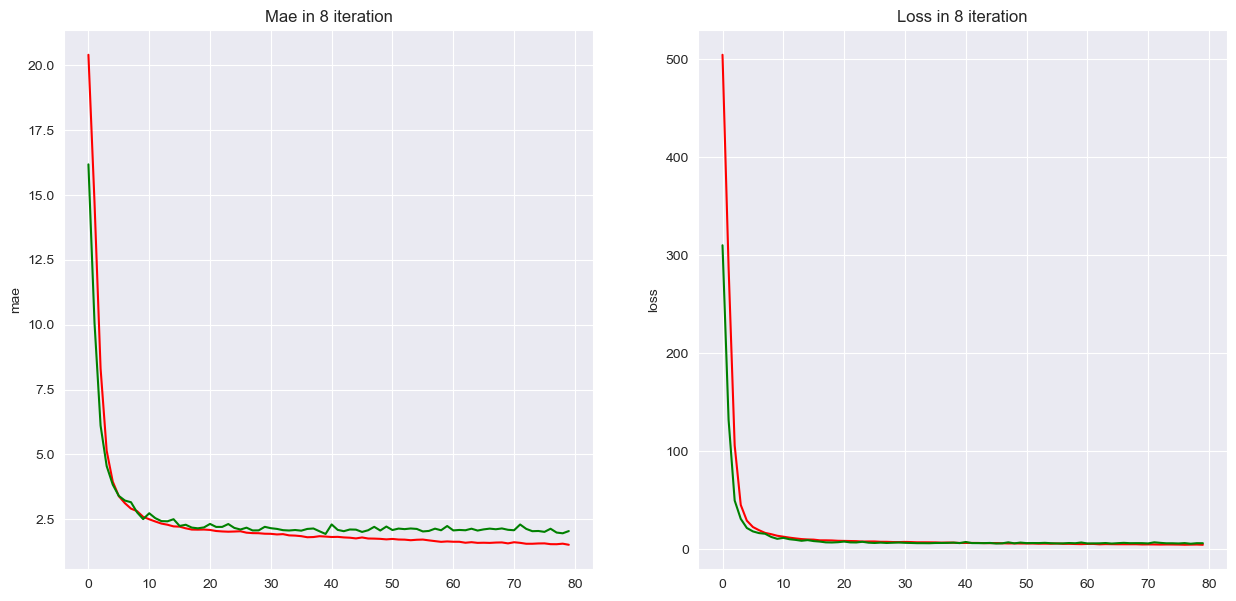

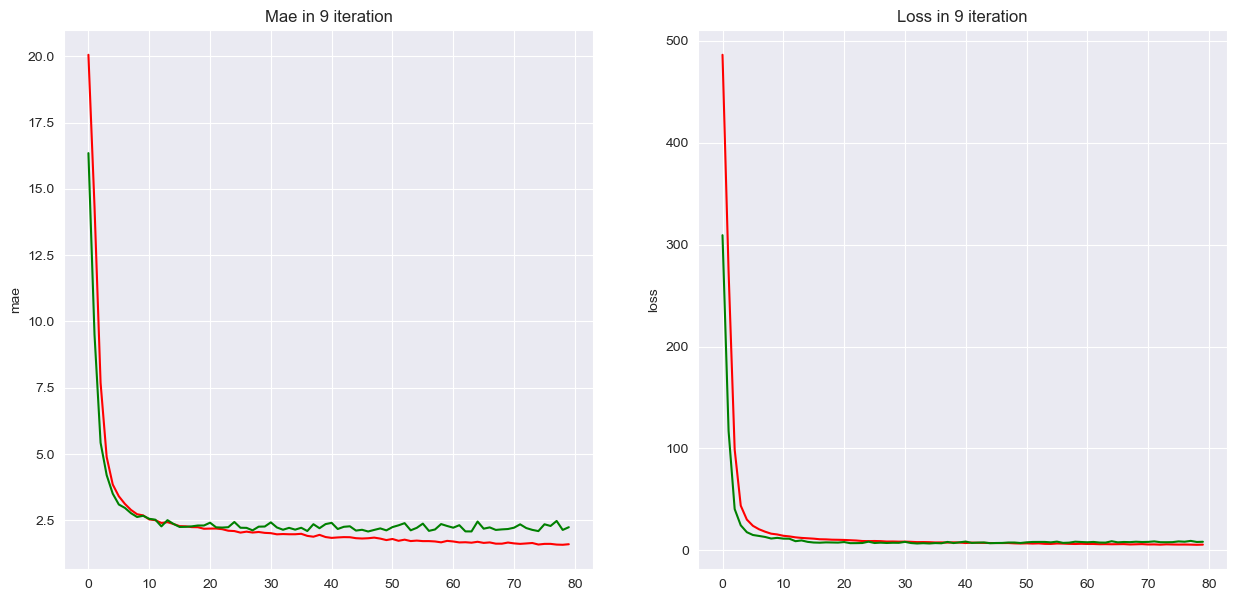

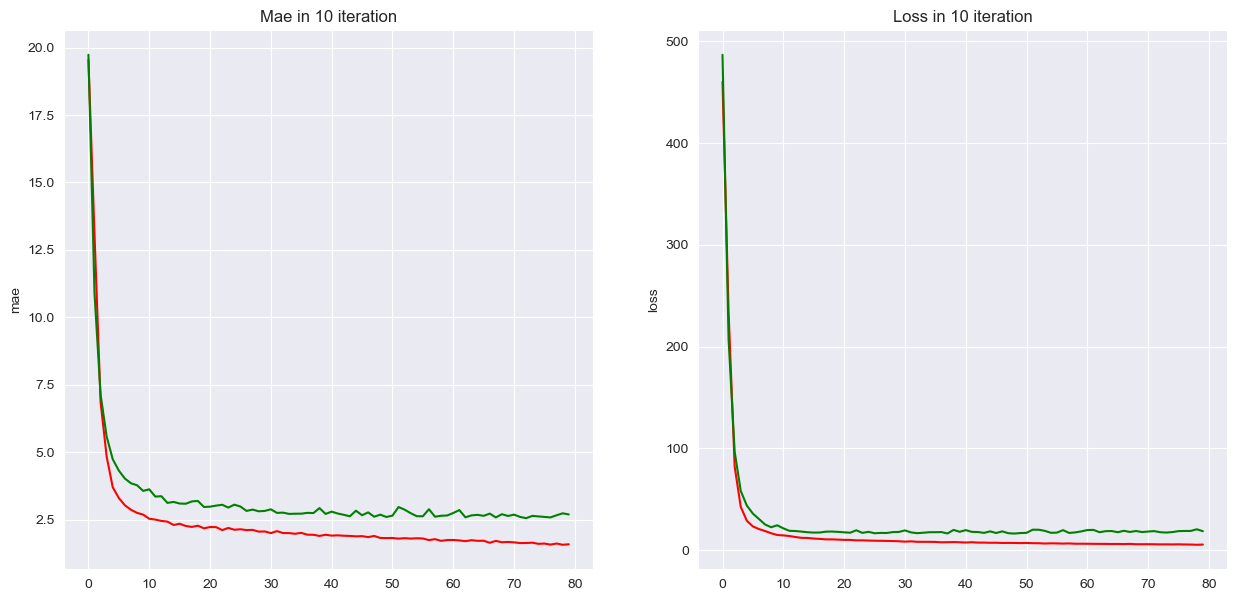

In [96]:
MAE, MSE = hand_cross_validation_model(k=10, num_epochs=80, batch_size=10, scaling_function=standardize)
MEAN_MAE_SCORE['k=10 e=80 w_OF'] = MAE
MEAN_MSE_SCORE['k=10 e=80 w_OF'] = MSE

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
All Scores MAE: [1.8261301517486572, 2.3698980808258057, 2.44287109375, 2.5580780506134033, 2.5388448238372803, 2.321108818054199]
Mean of MAE score ---> 2.3428218364715576
All Losses MSE: [6.9674906730651855, 9.193841934204102, 10.373072624206543, 11.60505199432373, 20.48724937438965, 8.183611869812012]
Mean of MSE loss ---> 11.135053078333536


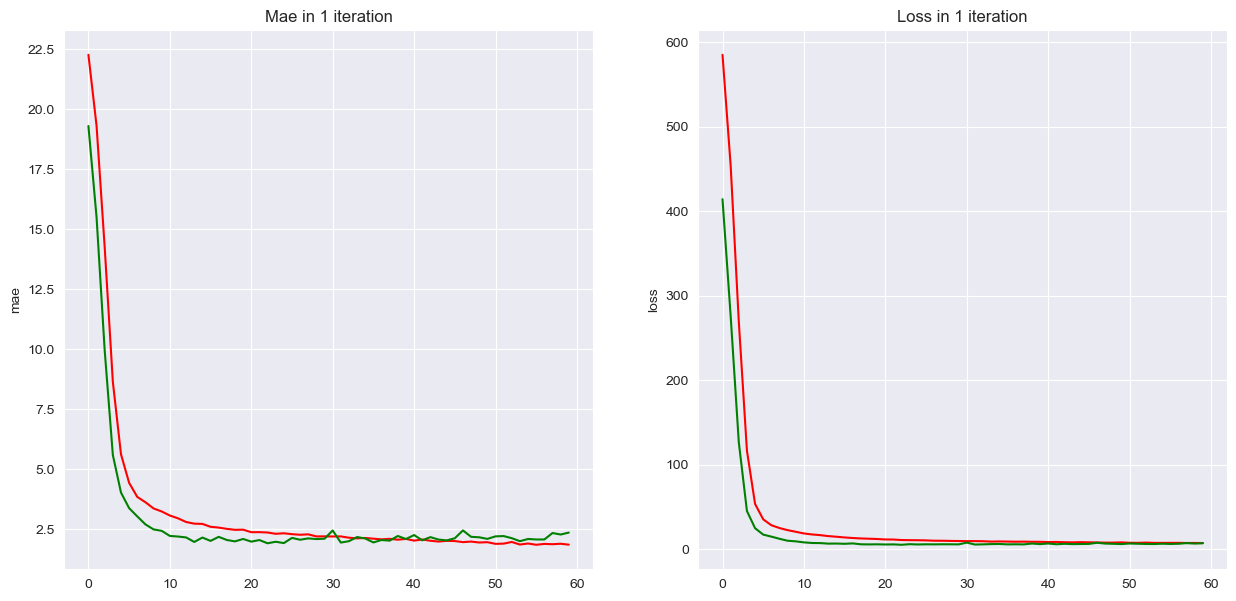

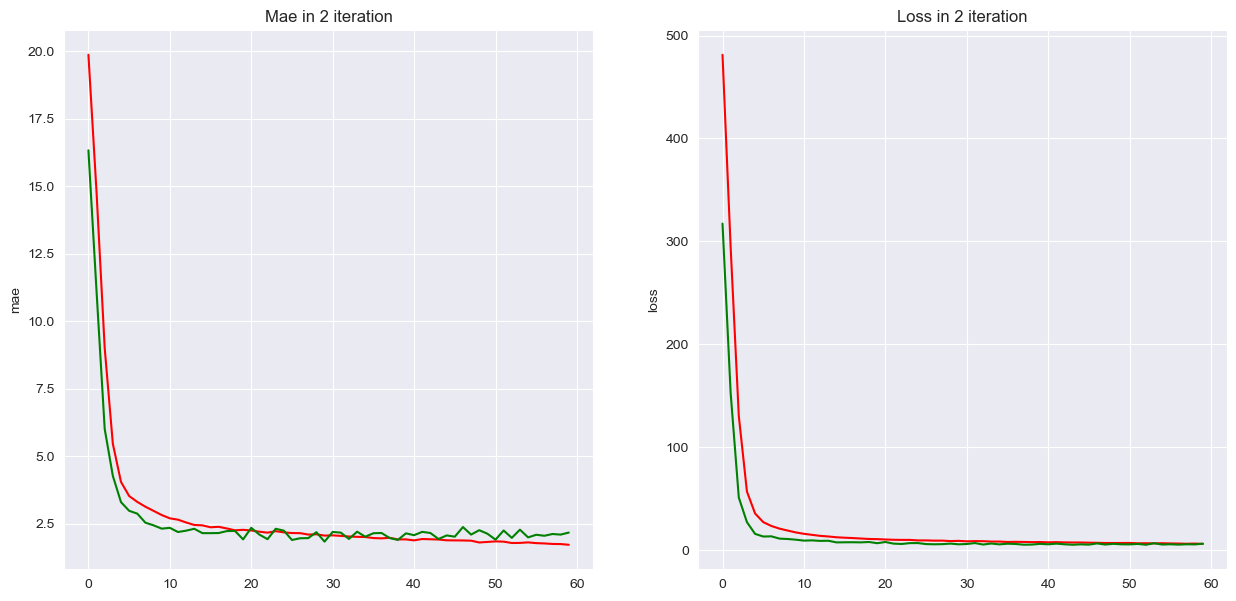

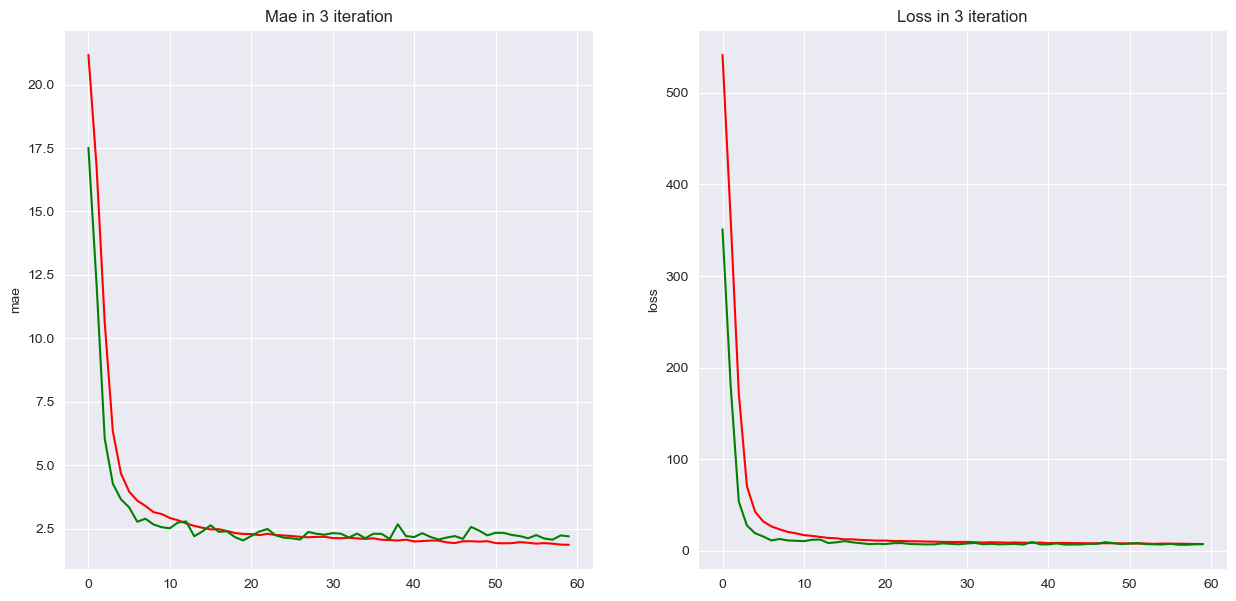

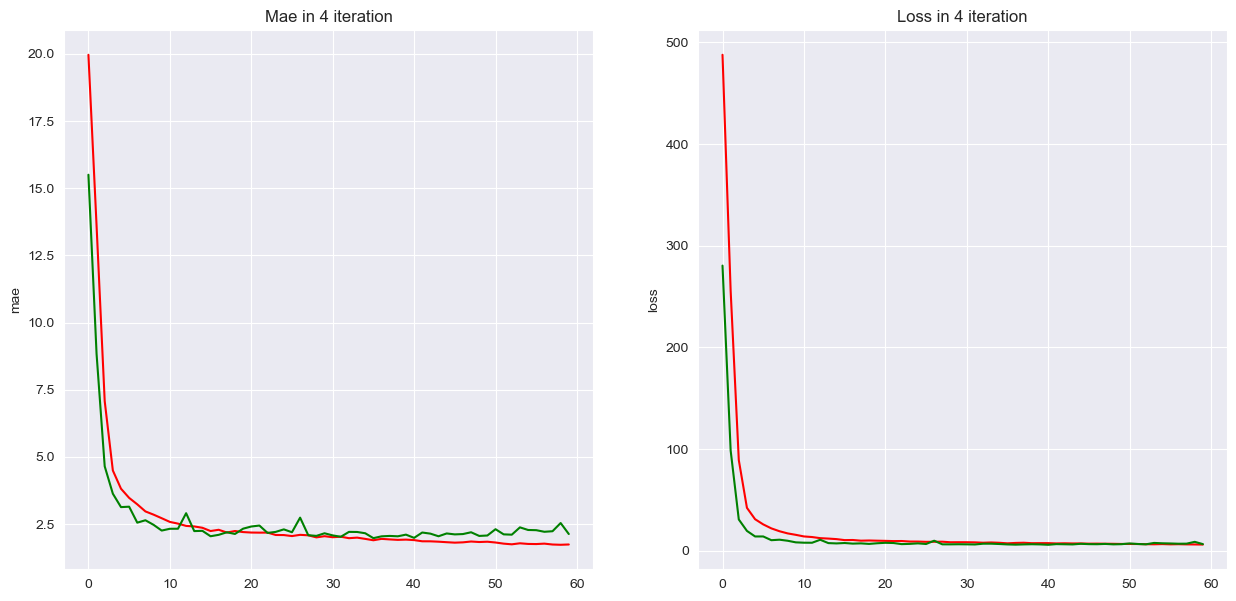

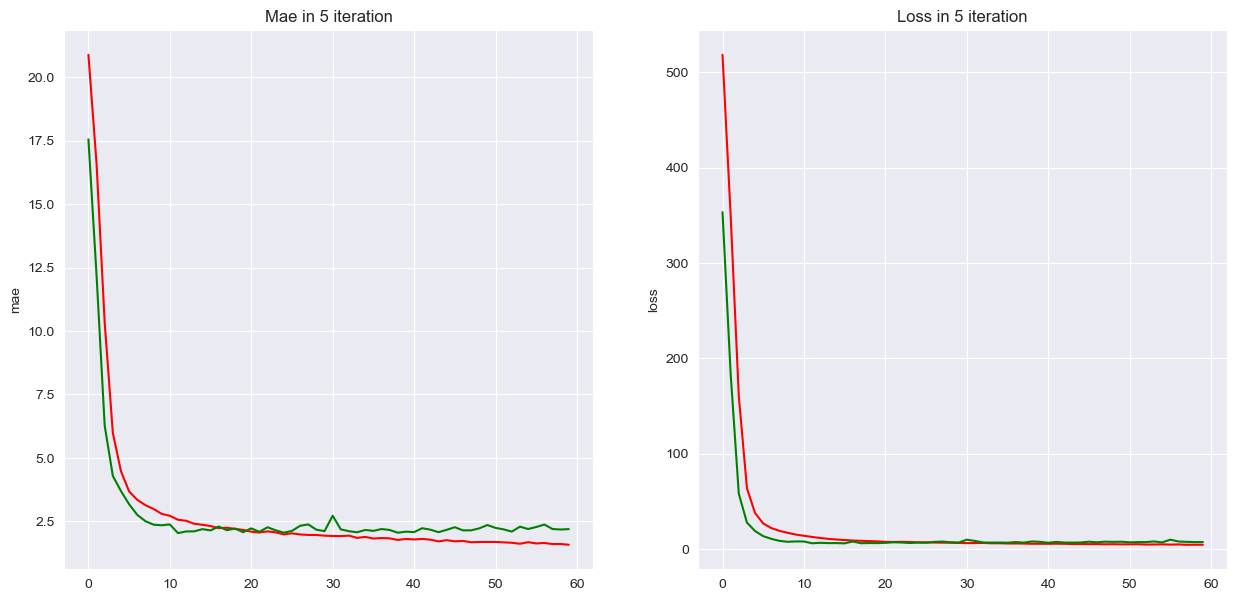

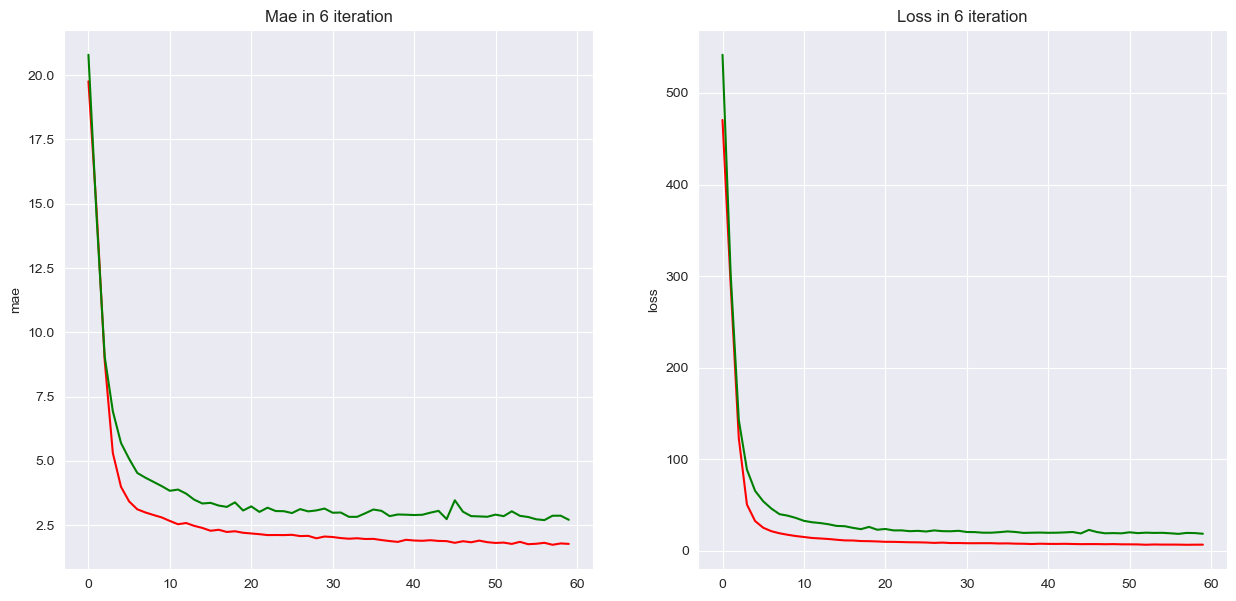

In [101]:
MAE, MSE = hand_cross_validation_model(k=6, num_epochs=60, batch_size=10, scaling_function=standardize)
MEAN_MAE_SCORE['optimal'] = MAE
MEAN_MSE_SCORE['optimal'] = MSE

# <-------------------------------------------------------------------- Final model comparison -------------------------------------------------------------------->

In [102]:
df_mae_score = pd.DataFrame(MEAN_MAE_SCORE.items(), columns=['Name', 'MAE'])
df_mae_score

,Name,MAE
0,default,2.566409
1,k=2 e=150,2.796197
2,k=10 e=80 w_OF,2.349495
3,optimal,2.342822


In [103]:
df_mse_score = pd.DataFrame(MEAN_MSE_SCORE.items(), columns=['Name', 'MSE'])
df_mse_score

,Name,MSE
0,default,11.990216
1,k=2 e=150,15.800340
2,k=10 e=80 w_OF,11.172896
3,optimal,11.135053


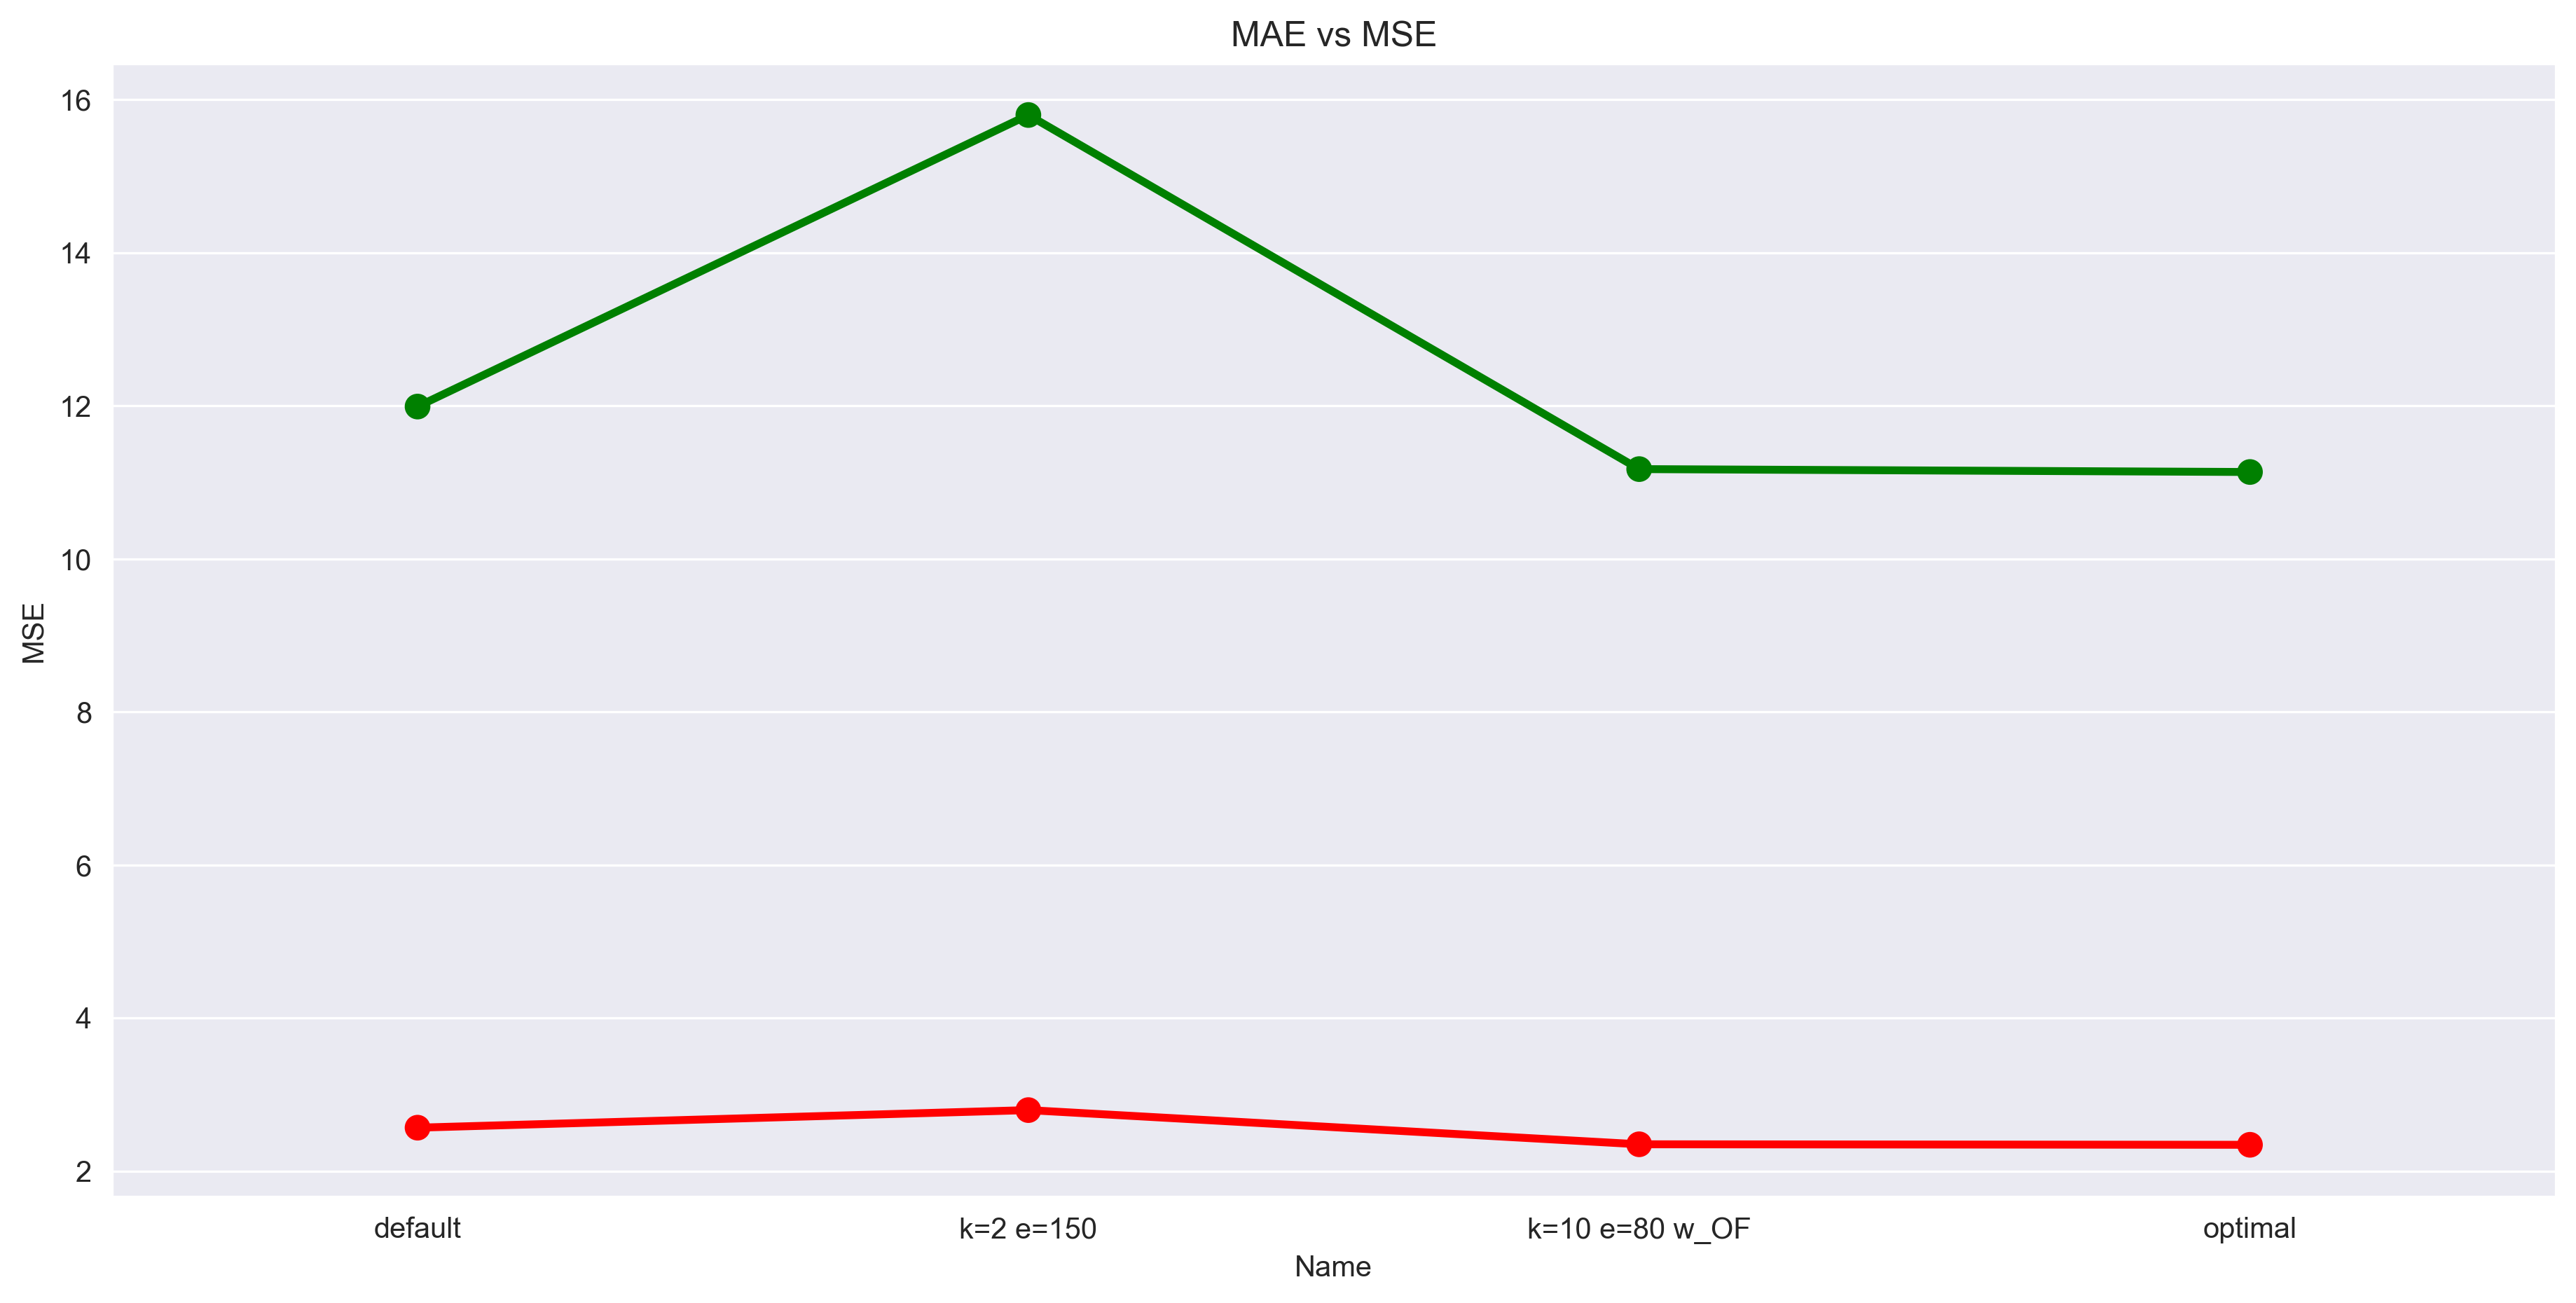

In [112]:
fig = plt.figure(figsize=(15,7), dpi=300)

sns.pointplot(data=df_mae_score, x='Name', y='MAE', color='red')
sns.pointplot(data=df_mse_score, x='Name', y='MSE', color='green')
plt.title('MAE vs MSE');